# CP8321 - Deep Learning Assignment #10

## Topic

Reliable Prostate Cancer Grading: Patch-Level Gleason Pattern Classification with Uncertainty Quantification using SICAPv2

## Objective

Develop a deep learning model that not only classifies prostate cancer image patches into
Gleason patterns (3, 4, 5) but also provides uncertainty estimates with each prediction. This helps
identify when the model is unsure, improving clinical trust and enabling selective prediction
(e.g., defer to human pathologist in ambiguous cases).
The project will explore Bayesian deep learning or Monte Carlo dropout, and assess how
incorporating uncertainty improves decision-making in prostate histopathology.

## 1. Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## 2. Extract Dataset

Use uploaded organized dataset from G-Drive

In [4]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/Deep Learning - Project Group 10/organized_dataset.zip'
!unzip -q "{zip_path}" -d /content/
!ls -lh /content/organized_dataset/

total 872K
-rw-r--r-- 1 root root  806 Nov 23 18:13 organization_report.json
drw-r--r-- 4 root root 4.0K Nov 23 19:09 test
-rw-r--r-- 1 root root 148K Nov 23 18:13 test_labels.csv
drw-r--r-- 4 root root 4.0K Nov 23 19:09 train
-rw-r--r-- 1 root root 581K Nov 23 18:13 train_labels.csv
drw-r--r-- 4 root root 4.0K Nov 23 19:09 val
-rw-r--r-- 1 root root 123K Nov 23 18:13 val_labels.csv


# 3. Define Imports

In [1]:
# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Data analysis
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Util
from pathlib import Path

## 4. ResNet18 Model
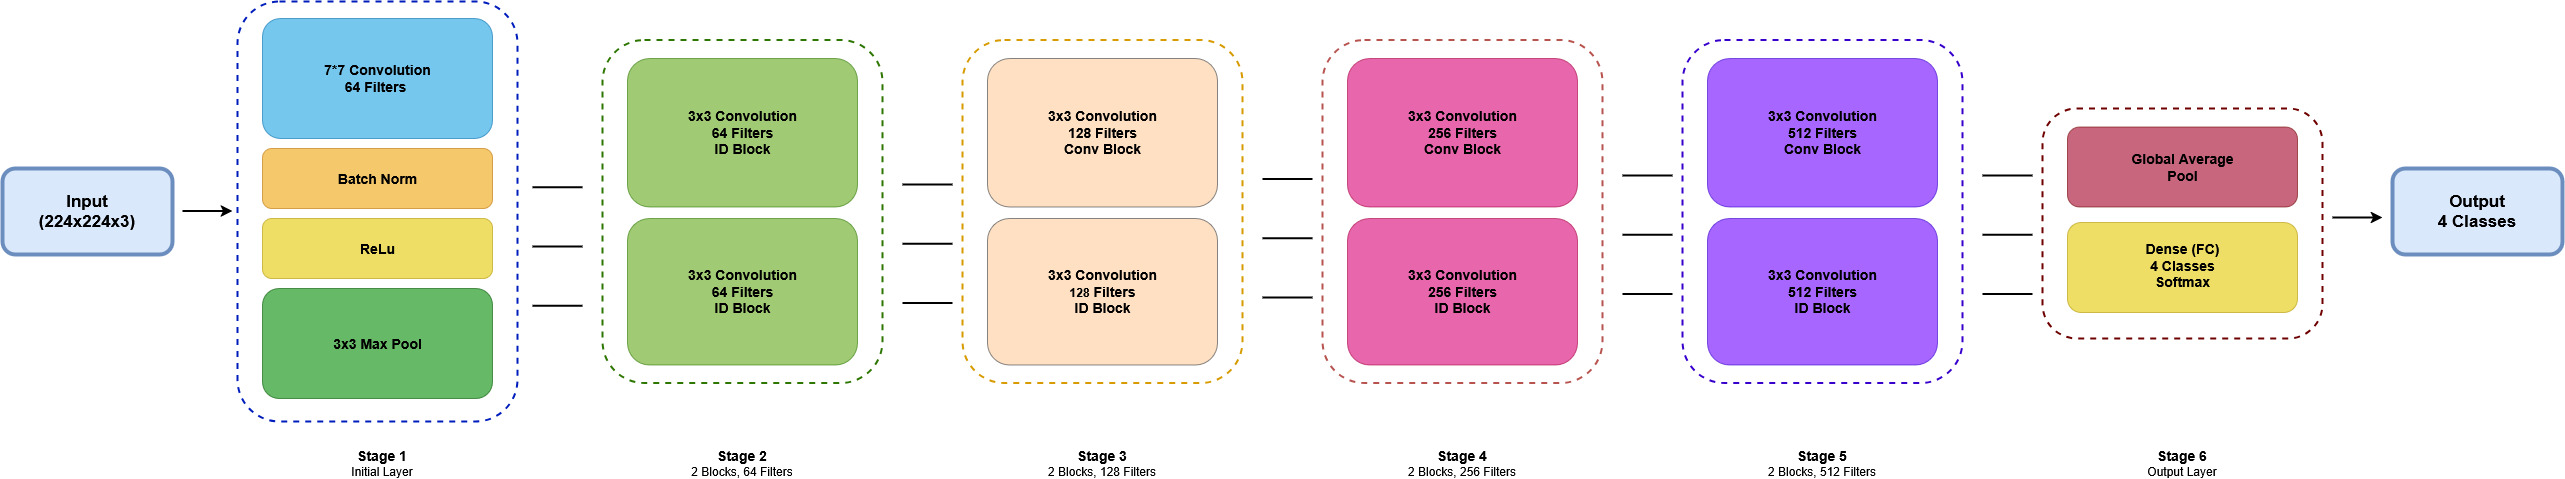

In [5]:
class ResidualBlock(layers.Layer):

    def __init__(self, filters, stride=1):
        super(ResidualBlock, self).__init__()

        # First convolution
        # Padding = same; implicitly handle zero padding
        self.conv1 = layers.Conv2D(filters, 3, strides=stride, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.relu1 = layers.ReLU()

        # Second convolution
        self.conv2 = layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False)
        self.bn2 = layers.BatchNormalization()

        # If spatial dimensions change and don't match
        if stride != 1:
            self.shortcut = keras.Sequential([
                layers.Conv2D(filters, 1, strides=stride, use_bias=False),
                layers.BatchNormalization()
            ])
        else:
            self.shortcut = lambda x: x

        # Activation function
        self.relu2 = layers.ReLU()

    def call(self, x, training=False):
        # Conv 1
        out = self.conv1(x)
        out = self.bn1(out, training=training)
        out = self.relu1(out)

        # Conv 2
        out = self.conv2(out)
        out = self.bn2(out, training=training)

        # Shortcut
        shortcut = self.shortcut(x)

        # Add and activiation function (relu)
        out = layers.Add()([out, shortcut])
        out = self.relu2(out)

        return out

def create_resnet18(num_classes=4, input_shape=(224, 224, 3)):
    """
    ResNet18 Model

    num_classes: Gleason Grading System splits into 4 categories
        1. Non-cancerous (NC)
        2. Grade 3 (G3)
        3. Grade 4 (G4)
        4. Grade 5 (G5)

    input_shape: Standard default 224x224 size with 3 RGB channels for colour images

    Input -> Stage 1 (conv, batch norm, relu, max pool) -> Stage 2 (2x convlution w/ 64 filters) -> Stage 3 ()
    """

    inputs = keras.Input(shape=input_shape)

    # Stage 1 - Initial Layer
    # - Extract low-level features such as edges, basic shapes
    # - Downsample and normalize to reduce computational overhead
    # - Retain only the most prominent features
    x = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Stage 2 - 64 filters
    # - Learn abstract representation of cell features in WSI
    # - Capture patterns
    x = ResidualBlock(64, stride=1)(x)
    x = ResidualBlock(64, stride=1)(x)

    # Stage 3 - 128 filters
    # - Downsample
    # - Learn mid-level features from WSI
    x = ResidualBlock(128, stride=2)(x)
    x = ResidualBlock(128, stride=1)(x)

    # Stage 4 - 256 filters
    # - Downsample further
    # - Learn higher level feature representations and larger-scale patterns
    # - Critical part for distingushing gleason grades
    x = ResidualBlock(256, stride=2)(x)
    x = ResidualBlock(256, stride=1)(x)

    # Stage 5 - 512 filters
    # - Learn most abstract, high-level features
    # - Directly inform final classification
    x = ResidualBlock(512, stride=2)(x)
    x = ResidualBlock(512, stride=1)(x)

    # Stage 6 - Output Layer
    # - Reduce to 512-demensional vector
    # - Each 512 value represents average activation of that feature across the entire image
    # - Summary of all learned features
    # - Maps 512 features to 4 class probabilties with proper probability distribution (Softmax)
    # - Outputs to P(NC), P(G3), P(G4), P(G5) with highest probability informing gleason grade prediction
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='resnet18')

    return model


# Compile with optimizations, loss, and our required metrics
# ADAM = Adaptive Moment Estimation (https://arxiv.org/abs/1412.6980)
# Categorical crossentropy measures difference between predicted probability distribution and true label (one hot encoding)
# Accuracy = percentage of predictions match true labels
# Create and compile model
model = create_resnet18(num_classes=4)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',  # Note: using sparse since labels are integers
    metrics=['accuracy']
)

model.summary()

Model: "resnet18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 112, 112, 64)   │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block (ResidualBlock)  │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_1                │ (None, 56, 56, 64)     │        74,240 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_2                │ (None, 28, 28, 128)    │       230,912 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_3                │ (None, 28, 28, 128)    │       295,936 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_4                │ (None, 14, 14, 256)    │       920,576 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_5                │ (None, 14, 14, 256)    │     1,181,696 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_6                │ (None, 7, 7, 512)      │     3,676,160 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_7                │ (None, 7, 7, 512)      │     4,722,688 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,188,164 (42.68 MB)

 Trainable params: 11,178,564 (42.64 MB)

 Non-trainable params: 9,600 (37.50 KB)

# 5. Create Data Pipeline

In [6]:
def create_dataset(data_dir, labels_csv, batch_size=32, shuffle=True, augment=False):
    df = pd.read_csv(labels_csv)
    data_dir = Path(data_dir)

    image_paths = [str(data_dir / 'images' / name) for name in df['image_name']]
    labels = df['label'].values

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    def load_and_preprocess(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_png(img, channels=3)
        # Resize and normalize
        img = tf.image.resize(img, [224, 224])
        img = tf.cast(img, tf.float32) / 255.0

        # Data augmentation (only for training)
        # This makes it harder for models to memorize and forces learning
        if augment:
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_flip_up_down(img)
            k = tf.random.uniform([], 0, 4, dtype=tf.int32)
            img = tf.image.rot90(img, k=k)
            img = tf.image.random_brightness(img, max_delta=0.1)
            img = tf.image.random_contrast(img, lower=0.9, upper=1.1)

        # ImageNet normalization
        mean = tf.constant([0.485, 0.456, 0.406])
        std = tf.constant([0.229, 0.224, 0.225])
        img = (img - mean) / std
        return img, label

    # Map preprocessing
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(1000)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

# Create datasets with augmentation for training only
train_dataset = create_dataset(
    '/content/organized_dataset/train',
    '/content/organized_dataset/train_labels.csv',
    batch_size=32,
    shuffle=True,
    augment=True
)

val_dataset = create_dataset(
    '/content/organized_dataset/val',
    '/content/organized_dataset/val_labels.csv',
    batch_size=32,
    shuffle=False,
    augment=False
)

print(f"Train samples: {len(pd.read_csv('/content/organized_dataset/train_labels.csv'))}")
print(f"Val samples: {len(pd.read_csv('/content/organized_dataset/val_labels.csv'))}")

Train samples: 8215
Val samples: 1744


# 6. Train Model

In [8]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        verbose=1,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1,
        min_lr=1e-7
    )
]

# Train
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

model.save('/content/drive/MyDrive/Deep Learning - Project Group 10/project10_model.keras')

Epoch 1/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.6259 - loss: 0.8936
Epoch 1: val_accuracy improved from -inf to 0.39048, saving model to best_model.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 79s 218ms/step - accuracy: 0.6263 - loss: 0.8929 - val_accuracy: 0.3905 - val_loss: 1.7691 - learning_rate: 1.0000e-04
Epoch 2/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.6030 - loss: 1.1186
Epoch 2: val_accuracy improved from 0.39048 to 0.48452, saving model to best_model.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 63s 182ms/step - accuracy: 0.6034 - loss: 1.1171 - val_accuracy: 0.4845 - val_loss: 1.8330 - learning_rate: 1.0000e-04
Epoch 3/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6114 - loss: 1.0461
Epoch 3: val_accuracy did not improve from 0.48452
257/257 ━━━━━━━━━━━━━━━━━━━━ 43s 156ms/step - accuracy: 0.6118 - loss: 1.0447 - val_accuracy: 0.3893 - val_loss: 4.4743 - learning_rate: 1.0000e-04
Epoch 4/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 

# 7. Evaluation

Evaluating model on validation set...

Validation Accuracy: 66.69%


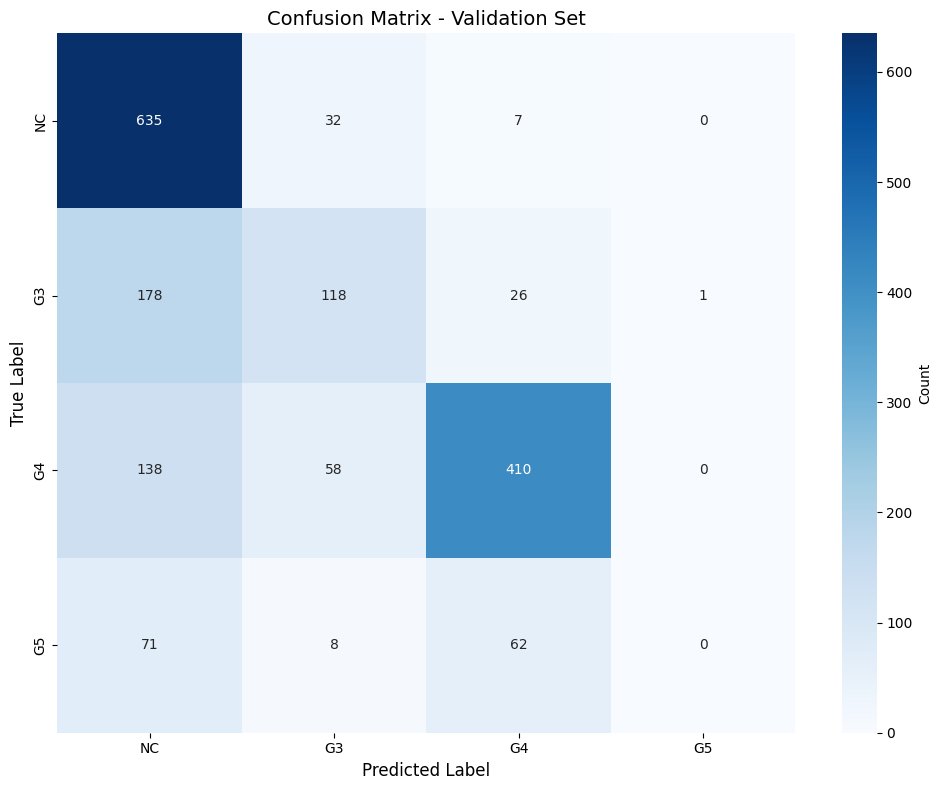


Confusion Matrix:
[[635  32   7   0]
 [178 118  26   1]
 [138  58 410   0]
 [ 71   8  62   0]]

Per-class statistics:

NC:
  Precision: 0.621
  Recall: 0.942
  F1-Score: 0.749
  Support: 674

G3:
  Precision: 0.546
  Recall: 0.365
  F1-Score: 0.438
  Support: 323

G4:
  Precision: 0.812
  Recall: 0.677
  F1-Score: 0.738
  Support: 606

G5:
  Precision: 0.000
  Recall: 0.000
  F1-Score: 0.000
  Support: 141

AUC Scores (One-vs-Rest):
NC: 0.921
G3: 0.822
G4: 0.902
G5: 0.639

Macro-Average AUC: 0.821


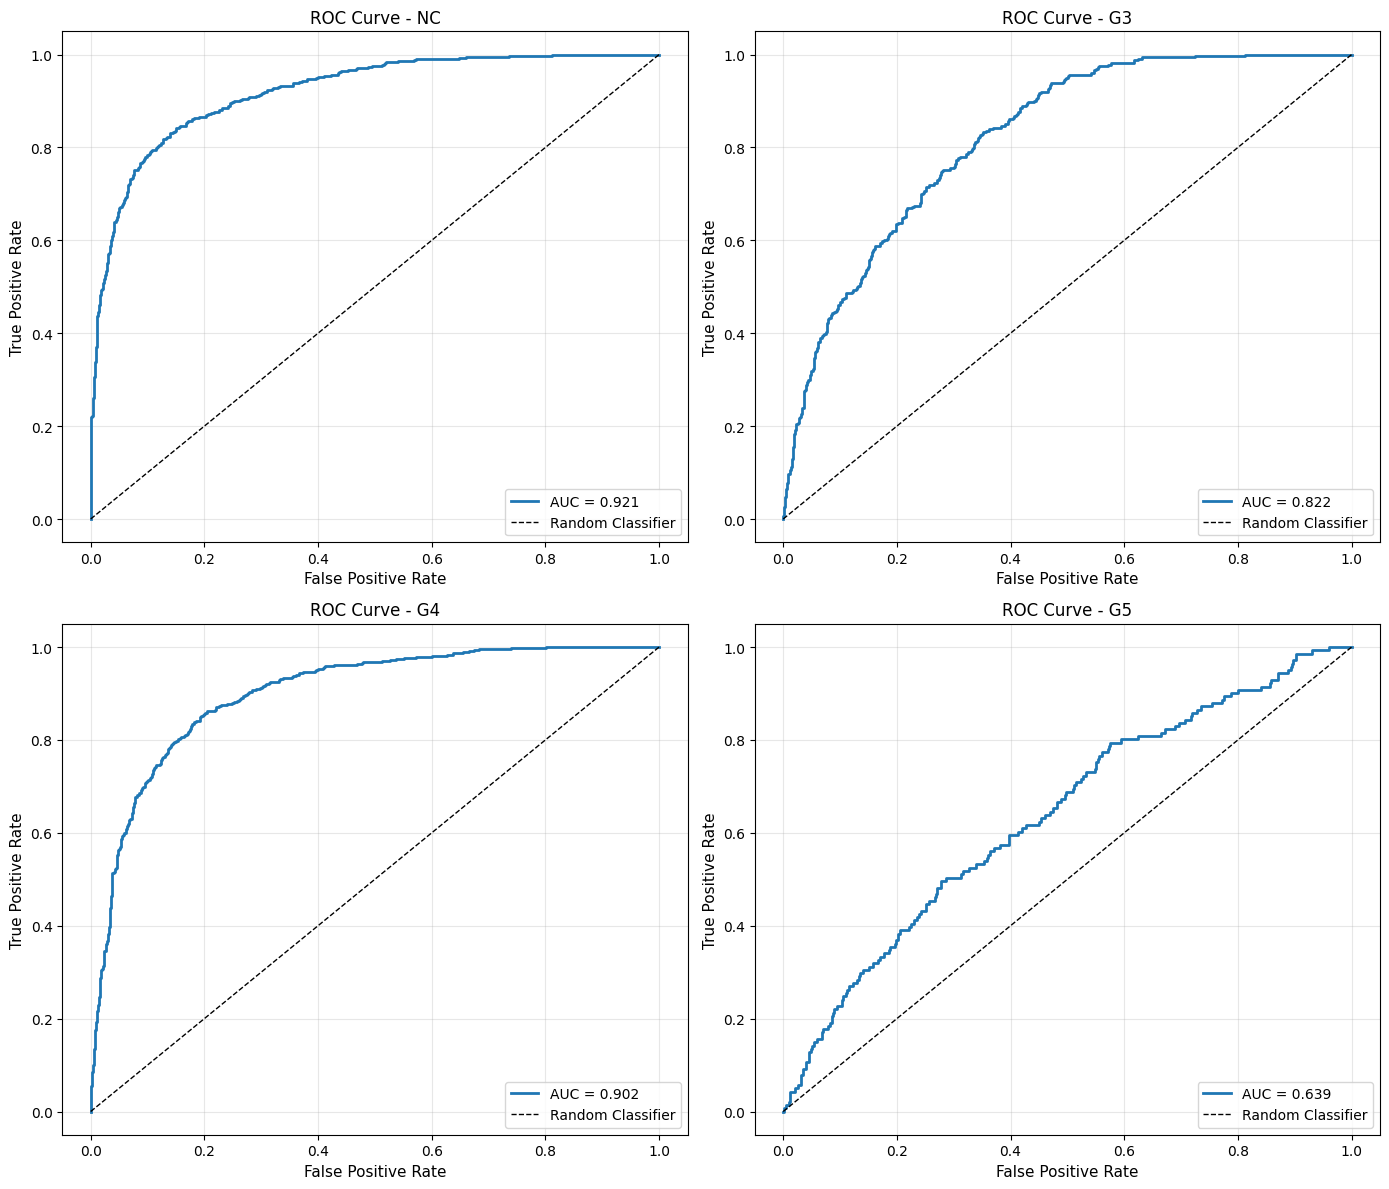


EVALUATION SUMMARY
Overall Accuracy: 66.69%
Macro-Average AUC: 0.821

Per-Class AUC Scores:
  NC: 0.921
  G3: 0.822
  G4: 0.902
  G5: 0.639


In [9]:


# ============================================
# 1. Get predictions on validation set
# ============================================
print("Evaluating model on validation set...")

# Get all predictions and true labels
y_true = []
y_pred = []
y_pred_proba = []  # For AUC calculation

for images, labels in val_dataset:
    predictions = model.predict(images, verbose=0)
    y_pred_proba.extend(predictions)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

# ============================================
# 2. Calculate Accuracy
# ============================================
accuracy = np.mean(y_true == y_pred)
print(f"\nValidation Accuracy: {accuracy*100:.2f}%")

# ============================================
# 3. Confusion Matrix
# ============================================
class_names = ['NC', 'G3', 'G4', 'G5']
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - Validation Set', fontsize=14)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Deep Learning - Project Group 10/confusion_matrix.png',
            dpi=150, bbox_inches='tight')
plt.show()

# Print confusion matrix statistics
print("\nConfusion Matrix:")
print(cm)
print("\nPer-class statistics:")
for i, class_name in enumerate(class_names):
    true_positives = cm[i, i]
    false_positives = cm[:, i].sum() - true_positives
    false_negatives = cm[i, :].sum() - true_positives
    true_negatives = cm.sum() - (true_positives + false_positives + false_negatives)

    # Calculate metrics
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\n{class_name}:")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall: {recall:.3f}")
    print(f"  F1-Score: {f1:.3f}")
    print(f"  Support: {cm[i, :].sum()}")

# ============================================
# 4. AUC per Class (One-vs-Rest)
# ============================================
print("\n" + "="*50)
print("AUC Scores (One-vs-Rest):")
print("="*50)

# Binarize labels for multi-class AUC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])
n_classes = y_true_bin.shape[1]

# Calculate AUC for each class
auc_scores = {}
for i, class_name in enumerate(class_names):
    try:
        auc_score = roc_auc_score(y_true_bin[:, i], y_pred_proba[:, i])
        auc_scores[class_name] = auc_score
        print(f"{class_name}: {auc_score:.3f}")
    except ValueError:
        print(f"{class_name}: Unable to calculate (class may not be in validation set)")
        auc_scores[class_name] = None

# Calculate macro-average AUC
valid_aucs = [v for v in auc_scores.values() if v is not None]
macro_auc = np.mean(valid_aucs) if valid_aucs else 0
print(f"\nMacro-Average AUC: {macro_auc:.3f}")

# ============================================
# 5. Plot ROC Curves
# ============================================
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for i, class_name in enumerate(class_names):
    if auc_scores[class_name] is not None:
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])

        axes[i].plot(fpr, tpr, linewidth=2,
                    label=f'AUC = {auc_scores[class_name]:.3f}')
        axes[i].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
        axes[i].set_xlabel('False Positive Rate', fontsize=11)
        axes[i].set_ylabel('True Positive Rate', fontsize=11)
        axes[i].set_title(f'ROC Curve - {class_name}', fontsize=12)
        axes[i].legend(loc='lower right', fontsize=10)
        axes[i].grid(True, alpha=0.3)
    else:
        axes[i].text(0.5, 0.5, f'No data for {class_name}',
                    ha='center', va='center', fontsize=12)
        axes[i].set_title(f'ROC Curve - {class_name}', fontsize=12)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Deep Learning - Project Group 10/roc_curves.png',
            dpi=150, bbox_inches='tight')
plt.show()

# ============================================
# 6. Summary Report
# ============================================
print("\n" + "="*50)
print("EVALUATION SUMMARY")
print("="*50)
print(f"Overall Accuracy: {accuracy*100:.2f}%")
print(f"Macro-Average AUC: {macro_auc:.3f}")
print(f"\nPer-Class AUC Scores:")
for class_name, auc_val in auc_scores.items():
    if auc_val is not None:
        print(f"  {class_name}: {auc_val:.3f}")